In [1]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')


Tensorflow version: 1.15.2


## Hyperparameters

In [2]:
batch_size = 32
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

## Load IBM data

In [76]:
train = pd.read_csv('train_timeframes_indicators2.csv')
test = pd.read_csv('test_timeframes_indicators2.csv')

## Calculate normalized percentage change of all columns

In [79]:
def get_df(df):    
    df = train[[t.split(':')[1] == '00' for t in train['time']]].copy()
    df = df[['datetime', 'open_60min', 'high_60min', 'low_60min', 'close_60min']]
    # df['datetime'] = df['datetime'].apply(lambda x: x.split()[0])
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close']
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)

    '''Calculate percentage change'''
    df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
    df['High'] = df['High'].pct_change() # Create arithmetic returns column
    df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
    df['Close'] = df['Close'].pct_change() # Create arithmetic returns column

    df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
    return df


###############################################################################
'''Create training, validation and test split'''

df_train = get_df(train)  # Training data are 80% of total data
df_val = get_df(test)

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))

df_train.head()

Training data shape: (32441, 4)
Validation data shape: (32441, 4)


,Open,High,Low,Close
1,0.001077,0.000764,0.000764,0.000764
2,-0.000037,-0.000028,-0.000028,-0.000028
3,0.000736,0.000515,0.000515,0.000515
4,0.001608,0.001563,0.001563,0.001563
5,-0.000734,-0.000101,-0.000101,-0.000101


## Plot daily IBM closing prices and volume

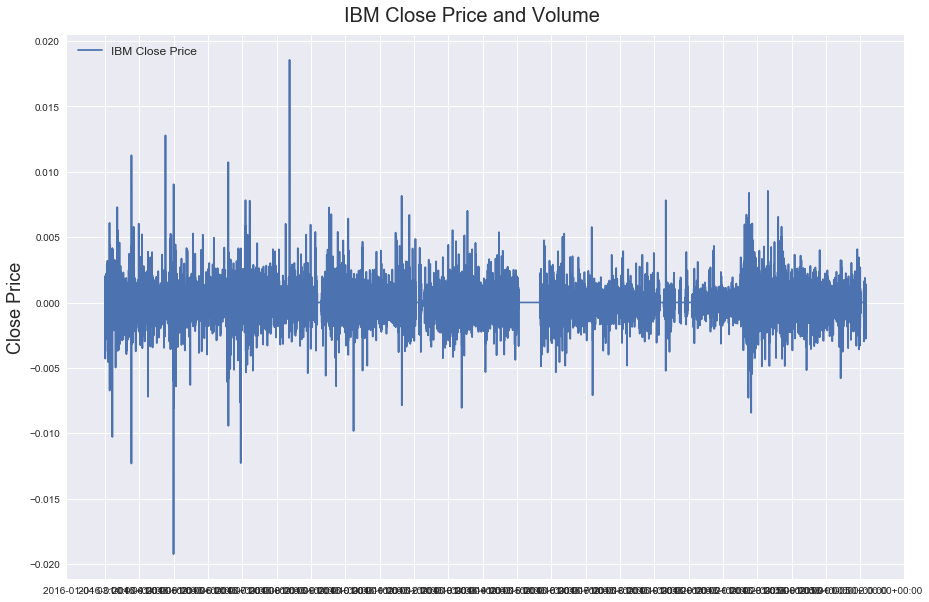

In [81]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("IBM Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(111)
ax1.plot(df_val['Close'], label='IBM Close Price')
ax1.set_xticks(range(0, df_val.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

## Plot daily changes of close prices and volume

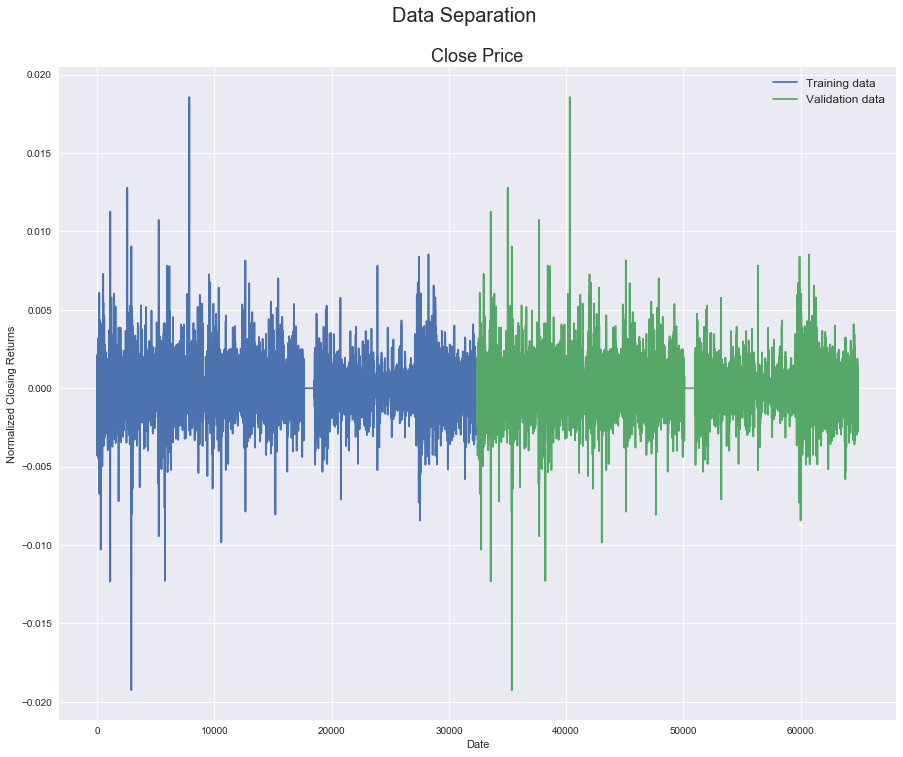

In [83]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(111)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)


## Create chunks of training, validation and test data

In [84]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)


## TimeVector

In [85]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

## Transformer

In [86]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

## Model

In [ ]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 4))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

model = tf.keras.models.load_model('/content/Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
ax31.legend(loc="best", fontsize=12)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 4)]     0                                            
__________________________________________________________________________________________________
time2_vector_1 (Time2Vector)    (None, 128, 2)       512         input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128, 6)       0           input_2[0][0]                    
                                                                 time2_vector_1[0][0]             
__________________________________________________________________________________________________
transformer_encoder_3 (Transfor (None, 128, 6)       86308       concatenate_1[0][0]        

Epoch 11/35
32288/32313 [============================>.] - ETA: 0s - loss: 1.0228e-06 - mean_absolute_error: 6.4711e-04 - mean_absolute_percentage_error: 18843.5586
Epoch 00011: val_loss did not improve from 0.00000
32313/32313 [==============================] - 519s 16ms/sample - loss: 1.0223e-06 - mean_absolute_error: 6.4694e-04 - mean_absolute_percentage_error: 18829.4180 - val_loss: 8.8951e-07 - val_mean_absolute_error: 5.9770e-04 - val_mean_absolute_percentage_error: 11027.3555
Epoch 12/35
32288/32313 [============================>.] - ETA: 0s - loss: 9.1523e-07 - mean_absolute_error: 6.1909e-04 - mean_absolute_percentage_error: 15052.3496
Epoch 00012: val_loss did not improve from 0.00000
32313/32313 [==============================] - 508s 16ms/sample - loss: 9.1589e-07 - mean_absolute_error: 6.1919e-04 - mean_absolute_percentage_error: 15052.0996 - val_loss: 9.9849e-07 - val_mean_absolute_error: 6.8340e-04 - val_mean_absolute_percentage_error: 31166.9512
Epoch 13/35
32288/32313 

Epoch 28/35
32288/32313 [============================>.] - ETA: 0s - loss: 9.3313e-07 - mean_absolute_error: 6.2899e-04 - mean_absolute_percentage_error: 16584.6914
Epoch 00028: val_loss did not improve from 0.00000
32313/32313 [==============================] - 423s 13ms/sample - loss: 9.3387e-07 - mean_absolute_error: 6.2919e-04 - mean_absolute_percentage_error: 16575.1035 - val_loss: 8.9219e-07 - val_mean_absolute_error: 5.9999e-04 - val_mean_absolute_percentage_error: 11260.1875
Epoch 29/35
32288/32313 [============================>.] - ETA: 0s - loss: 9.2168e-07 - mean_absolute_error: 6.2395e-04 - mean_absolute_percentage_error: 16264.6914
Epoch 00029: val_loss did not improve from 0.00000
32313/32313 [==============================] - 416s 13ms/sample - loss: 9.2128e-07 - mean_absolute_error: 6.2386e-04 - mean_absolute_percentage_error: 16257.8623 - val_loss: 9.0564e-07 - val_mean_absolute_error: 6.1225e-04 - val_mean_absolute_percentage_error: 15080.7275
Epoch 30/35
32288/32313 

## Model metrics

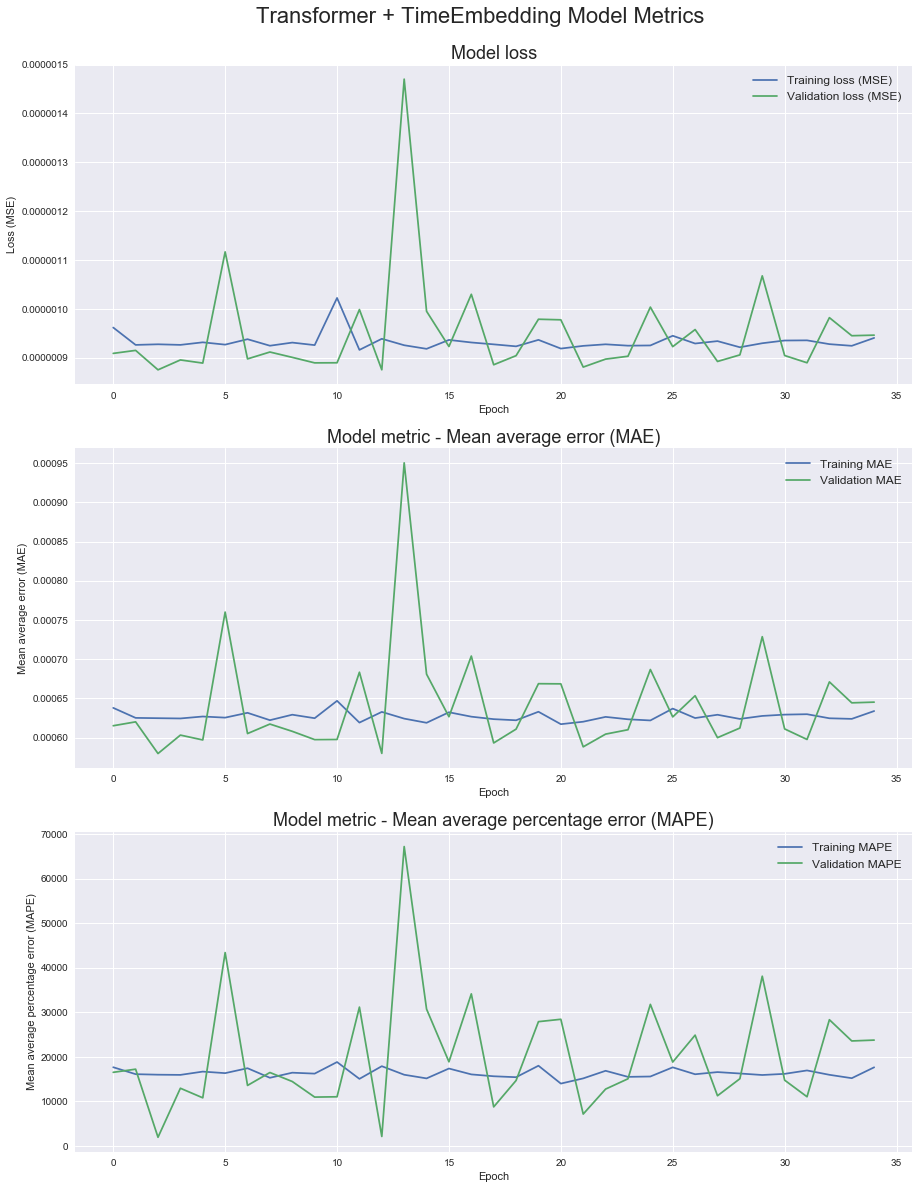

In [92]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mean_absolute_error'], label='Training MAE')
ax2.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mean_absolute_percentage_error'], label='Training MAPE')
ax3.plot(history.history['val_mean_absolute_percentage_error'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

## Model architecture overview

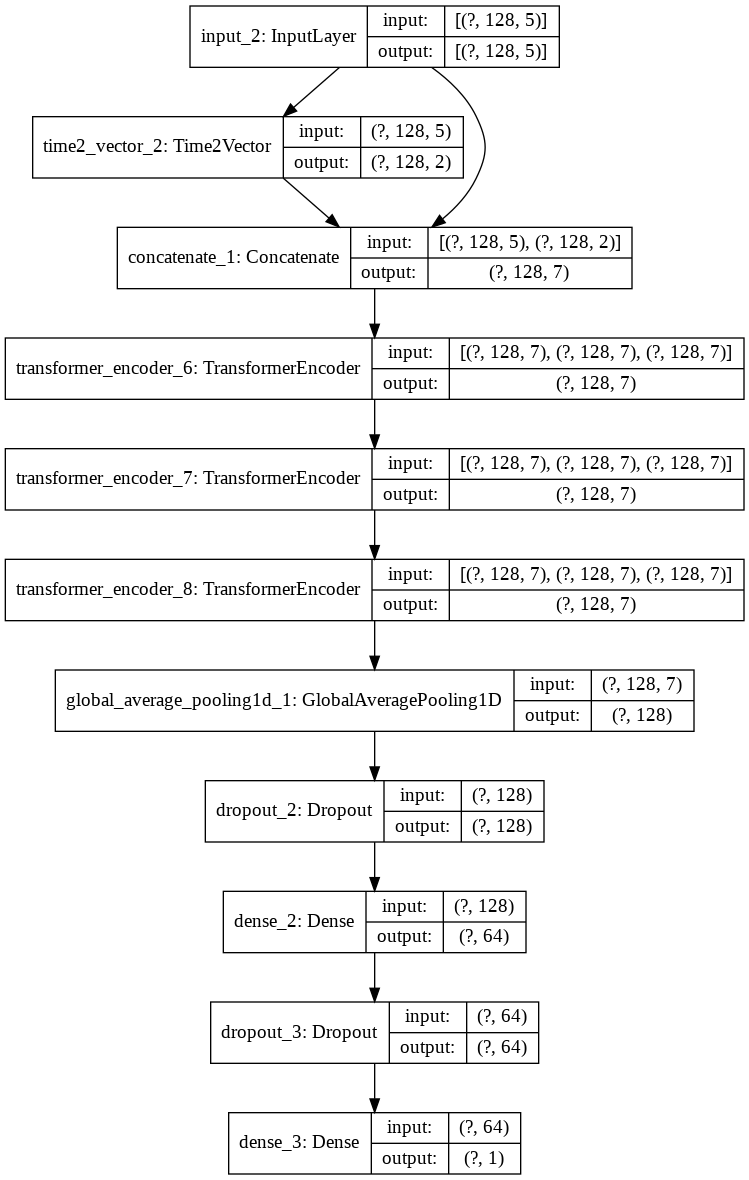

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="IBM_Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)

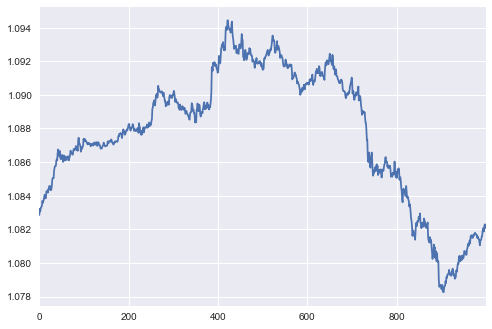

In [96]:
train['close_1min'].iloc[:1000].plot()

In [97]:
train

,datetime,time,date,spread,close_bid_1min,open_1min,high_1min,low_1min,close_1min,day_high,...,CDLPIERCING_60min,CDLMORNINGDOJISTAR_60min,CDLDOJISTAR_60min,CDLEVENINGSTAR_60min,CDLEVENINGDOJISTAR_60min,CDLSPINNINGTOP_60min,CDL2CROWS_60min,CDL3BLACKCROWS_60min,CDL3WHITESOLDIERS_60min,CDLHARAMICROSS_60min
0,2016-01-04 01:19:00+00:00,01:19:00,20160104,0.00020,1.08266,1.08318,1.08323,1.08282,1.08286,1.08576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-01-04 01:20:00+00:00,01:20:00,20160104,0.00018,1.08304,1.08286,1.08329,1.08286,1.08322,1.08576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-01-04 01:21:00+00:00,01:21:00,20160104,0.00018,1.08288,1.08320,1.08320,1.08293,1.08306,1.08576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-01-04 01:22:00+00:00,01:22:00,20160104,0.00019,1.08303,1.08308,1.08323,1.08306,1.08322,1.08576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-01-04 01:23:00+00:00,01:23:00,20160104,0.00017,1.08315,1.08321,1.08332,1.08316,1.08332,1.08576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899085,2020-12-31 21:56:00+00:00,21:56:00,20201231,0.00025,1.22159,1.22194,1.22195,1.22180,1.22184,1.23097,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1899086,2020-12-31 21:57:00+00:00,21:57:00,20201231,0.00022,1.22159,1.22184,1.22186,1.22173,1.22181,1.23097,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1899087,2020-12-31 21:58:00+00:00,21:58:00,20201231,0.00061,1.22134,1.22181,1.22198,1.22177,1.22195,1.23097,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1899088,2020-12-31 21:59:00+00:00,21:59:00,20201231,0.00069,1.22121,1.22195,1.22195,1.22190,1.22190,1.23097,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
def get_return(ps, trues, t, threshold=1.1, r=1.0, spread=0.00017):
    diff = ps * t['Close'].values/100
    profits = trues[abs(diff) > threshold * spread]
    for i in range(len(profits)):
        r = r * (1 + margin_size*np.sign(diff[i])*profits[i])
    return r

In [105]:
# train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

In [113]:
len(val_pred), len(df_val)-seq_len, len(val_data[seq_len:])

(32313, 32313, 32313)

In [124]:
get_return(val_pred.flatten(), val_data[seq_len:], df_val.iloc[seq_len:], threshold=0.5, r=1.0)

1.0

In [128]:
X_train

array([[[ 1.07725879e-03,  7.63885693e-04,  7.63885693e-04,
          7.63885693e-04],
        [-3.67897283e-05, -2.75892512e-05, -2.75892512e-05,
         -2.75892512e-05],
        [ 7.35821637e-04,  5.15013565e-04,  5.15013565e-04,
          5.15013565e-04],
        ...,
        [ 1.41463504e-03,  1.03785889e-03,  1.03785889e-03,
          1.03785889e-03],
        [-1.92632274e-04, -5.50504170e-05, -5.50504170e-05,
         -5.50504170e-05],
        [ 3.66989311e-05,  2.84442813e-04,  2.84442813e-04,
          2.84442813e-04]],

       [[-3.67897283e-05, -2.75892512e-05, -2.75892512e-05,
         -2.75892512e-05],
        [ 7.35821637e-04,  5.15013565e-04,  5.15013565e-04,
          5.15013565e-04],
        [ 1.60842632e-03,  1.56262926e-03,  1.56262926e-03,
          1.56262926e-03],
        ...,
        [-1.92632274e-04, -5.50504170e-05, -5.50504170e-05,
         -5.50504170e-05],
        [ 3.66989311e-05,  2.84442813e-04,  2.84442813e-04,
          2.84442813e-04],
        [-1.651